Привет, Владислава!)
<br> Меня зовут Дуолан 👋 Буду проверять твой проект. Давай вместе доведем его до идеала 😉
<br> Дальнейшее общение будет происходить на «ты», если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий («исправил», «не понятно как исправить ошибку», ...)
<br> Пожалуйста, не удаляй мои комментарии, они будут необходимы для повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-warning">
<b>⚠️ Совет:</b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b> Если требуются исправления
</div>

Работа не может быть принята с красными комментариями.

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from phik.report import correlation_report, plot_correlation_matrix
from skimpy import skim, clean_columns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import time

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Импорт выглядит отлично 👍
</div>

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv') 

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Нули в цене, мощности, месяце регистрации необходимо обработать. Так же год регистрации 1000.Столбец с числом фото неинформативный,содержит только нули.Нужно удалить.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Ты хорошо владеешь методами первичного анализа данных 👍
</div>

In [6]:
# Приводим наименование признаков к стандартному виду
data = clean_columns(data)
data.columns

16 column names have been cleaned

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Работать с такими названиями гораздо удобнее)
</div>

In [7]:
data.shape

(354369, 16)

In [8]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [9]:
data.duplicated().sum()

4

In [10]:
#Удаляем явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

От явных дубликатов избавились 👍
</div>

Поменяем формат даты скачивания, даты создания анкеты и даты последней активности.

In [11]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'],format='%Y-%m-%d')
data['date_created'] = pd.to_datetime(data['date_created'],format='%Y-%m-%d')
data['last_seen'] = pd.to_datetime(data['last_seen'],format='%Y-%m-%d')

### Признак price

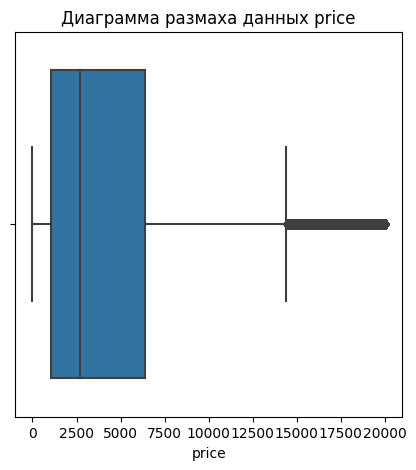

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='price',data = data)
plt.title('Диаграмма размаха данных price')
plt.xlabel('price')
plt.show()


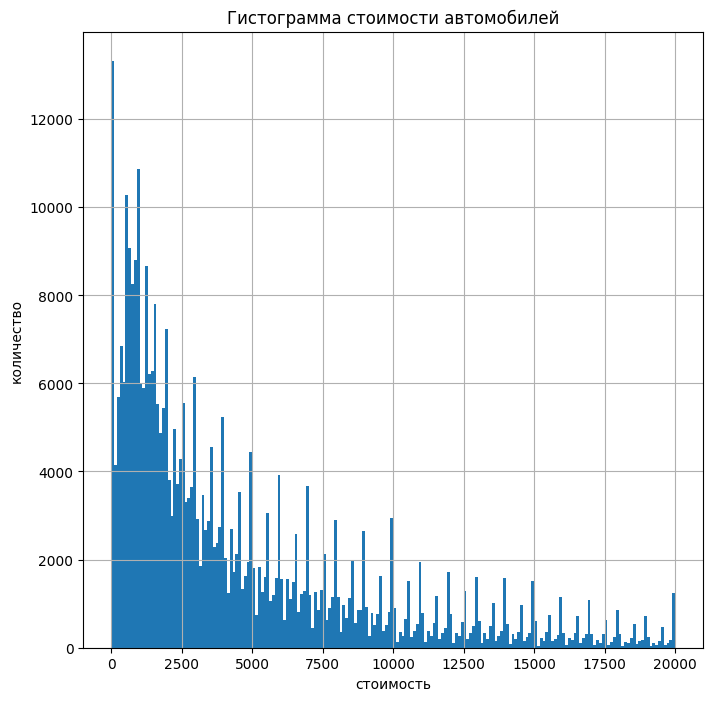

In [13]:
data['price'].hist(bins= 200,figsize=(8, 8))
plt.title('Гистограмма стоимости автомобилей')
plt.ylabel('количество')
plt.xlabel('стоимость')
plt.show()

In [14]:
data.query('price == 0').shape

(10772, 16)

In [15]:
q = np.quantile(data['price'], 0.95)
q

14600.0

In [16]:
data.query('price > @q').shape

(17652, 16)

На данном этапе пока уберу только цену со значением 0, так как предсказывать нулевую стоимость бессмысленно.

Так же отмечу что имеются скачки в распределении стоимости,они приходятся на целые значения, предполагаю,что люди просто округляют стоимость в объявлении до удобной суммы.

Выбросы за пределы 14600 евро составляют довольно большую часть данных, пока оставлю.

In [17]:
data = data.query('price != 0')

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

В данных остались машины только с адекватной ценой 👍
</div>

### Признак registration_year

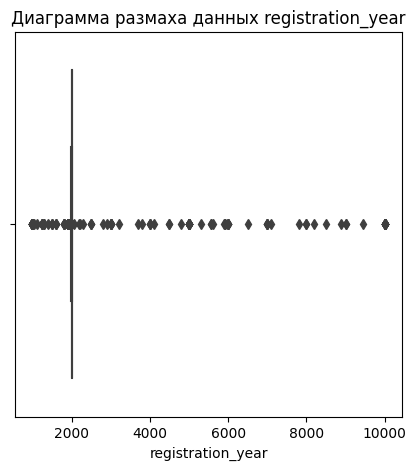

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='registration_year',data = data)
plt.title('Диаграмма размаха данных registration_year')
plt.xlabel('registration_year')
plt.show()

Отбросим год регистарации позже даты публикации объявления и ниже 0,01 квантиля.

In [19]:
data['year_created'] = data['date_created'].dt.year # создадим признак только с годом создания публикации

In [20]:
data['year_created'].unique()

array([2016, 2015, 2014], dtype=int64)

In [21]:
q_reg_ye = np.quantile(data['registration_year'], 0.01)
q_reg_ye

1980.0

In [22]:
data = data.query('registration_year <= year_created')
data = data.query('registration_year >= @q_reg_ye ')

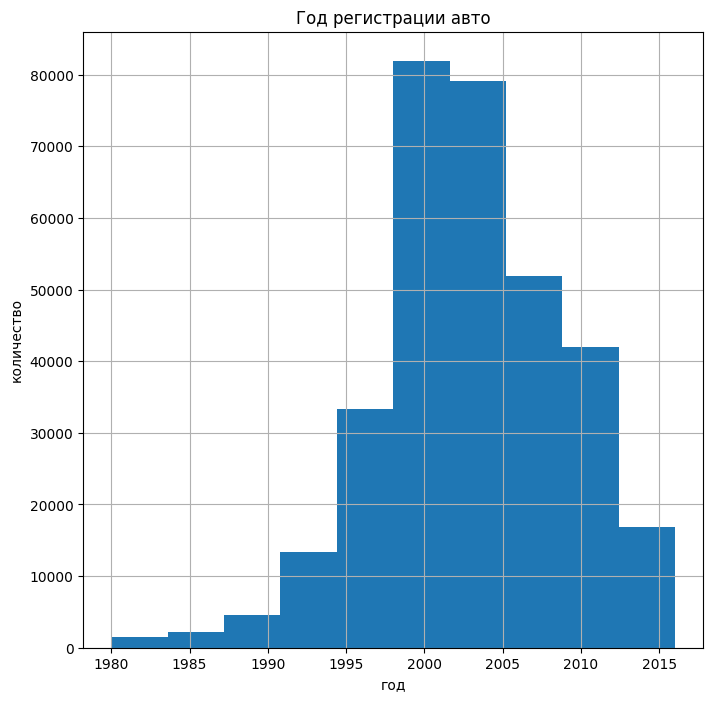

In [23]:
data['registration_year'].hist(bins= 10,figsize=(8, 8))
plt.title('Год регистрации авто')
plt.ylabel('количество')
plt.xlabel('год')
plt.show()

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Молодец, что для верхней границы используешь дату скачивания анкеты 👍
</div>

### Признак power

In [24]:
data.query('power==0').shape

(31968, 17)

In [25]:
data.query('power==0').pivot_table(values='power',
    index='brand',
    aggfunc='count')

,power
brand,
alfa_romeo,164
audi,1975
bmw,2417
chevrolet,167
chrysler,153
citroen,517
dacia,64
daewoo,93
daihatsu,133


Предполагала зависимость мощности от бренда, что мультиколениарность показала,но результаты предсказаний стали хуже,поэтому просто убрала нулевые значения.

In [26]:
# #Заменим нулевые значения мощности на среднее по бренду
# for i in data['brand'].unique():
#     data.loc[(data['brand']==i) & (data['power']==0),'power'] = \
#     data.loc[data['brand']==i ,'power'].mean()

Hennessey Venom F5 является самой мощной машиной с количеством лошадиных сил 1600, которую вряд ли будут продавать на подобных сервисах.Поэтому верхний предел мощности уберем по 0,99 квантилю.

Peel P50 самый маломощьный автомобиль 4,2 л.с.

In [27]:
q_power = np.quantile(data['power'], 0.99)
q_power

300.0

In [28]:
data.query('power > @q_power ').shape

(3231, 17)

In [29]:
data = data.loc[ (data['power'] >= 4) & (data['power'] < q_power)]

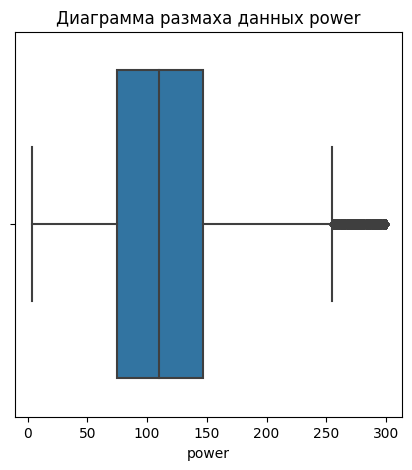

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='power',data = data)
plt.title('Диаграмма размаха данных power')
plt.xlabel('power')
plt.show()

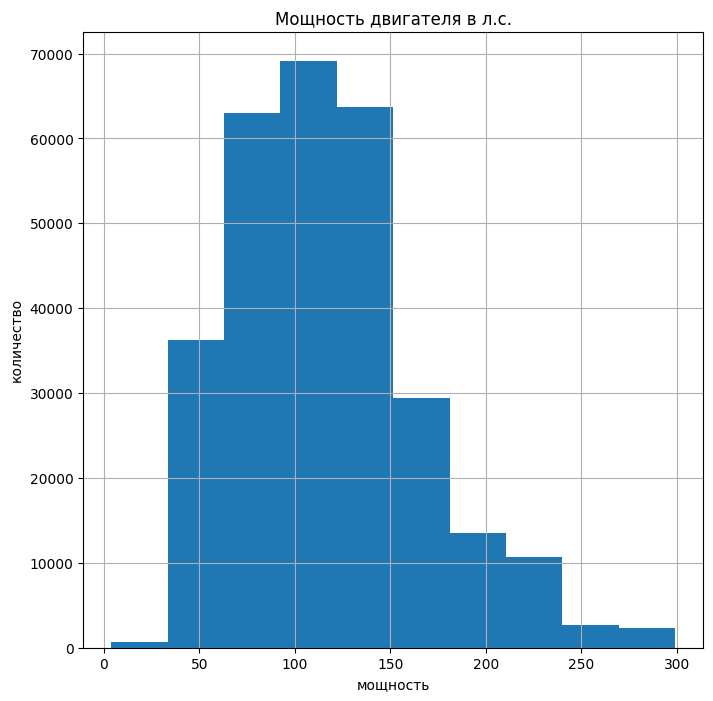

In [31]:
data['power'].hist(bins= 10,figsize=(8, 8))
plt.title('Мощность двигателя в л.с.')
plt.ylabel('количество')
plt.xlabel('мощность')
plt.show()

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Мощность ограничили 👍
</div>

### Признаки kilometer, registration_month, number_of_pictures

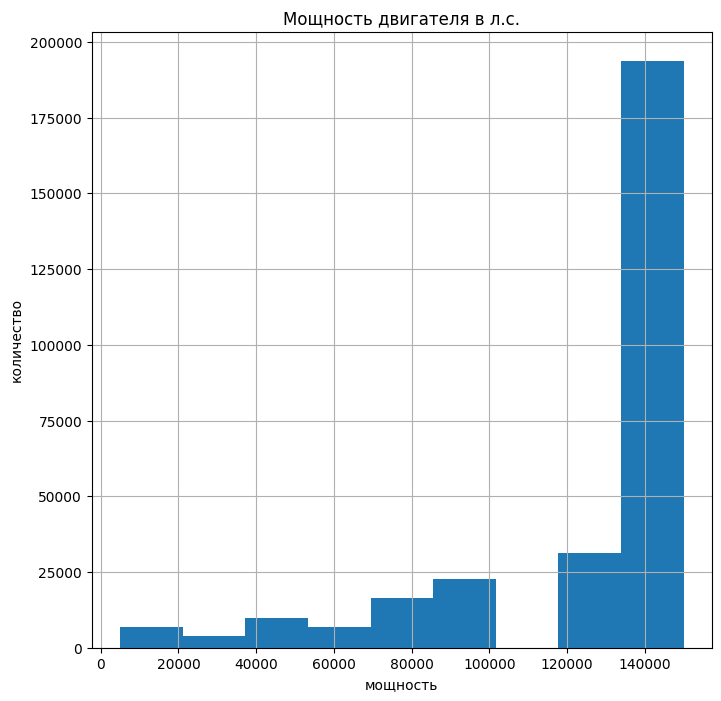

In [32]:
data['kilometer'].hist(bins= 9,figsize=(8, 8))
plt.title('Мощность двигателя в л.с.')
plt.ylabel('количество')
plt.xlabel('мощность')
plt.show()

In [33]:
data['kilometer'].value_counts()

150000    193667
125000     31316
100000     12452
90000      10106
80000       8829
70000       7636
60000       6703
50000       5537
40000       4416
30000       3828
20000       3185
5000        2672
10000        876
Name: kilometer, dtype: int64

Очень большое количество объявлений с пробегом в 150000 км, могу предположить,что у сервиса есть какое-то ограничение при публикации объявлений, нужно уточнять.

In [34]:
data['registration_month'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [35]:
data.query('registration_month == 0').shape

(17651, 17)

Большое количество объявлением с месяцем равным 0, предположу что пользователи просто не знали точного месяца.Удалять данные пока не буду. Возможно данный признак не важен и можно будет его убрать не затронув данные.

In [36]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

Признак неинформативный,удаляю.

In [37]:
data = data.drop(['number_of_pictures'],axis=1)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 👍
</div>

### Признаки vehicle_type,  gearbox, fuel_type, model, brand, repaired

In [38]:
data['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [39]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [40]:
data['fuel_type'].value_counts()

petrol      183228
gasoline     87471
lpg           4387
cng            481
hybrid         201
other           73
electric        71
Name: fuel_type, dtype: int64

Поскольку petrol и gasoline это бензин,и большинство пользователей указывают petrol, заменю на него. А так же пропуски категорией other.

В данных vehicle_type и gearbox нет никаких особенностей, кроме пропусков. \
Пропуски в vehicle_type заменю на уже существующую категорию other.\
Пропуски в gearbox удалю.

In [41]:
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')
data['fuel_type'] = data['fuel_type'].fillna('other')

In [42]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [43]:
data = data.dropna(subset=['gearbox'])

In [44]:
data['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'arosa', 'other', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'astra', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a1',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er',
       'combo', 'corsa', '80', '147', 'z_reihe', 'sorento', 'ibiza',
       'eos', 'touran', 'getz', 'insignia', 'ka', 'almera', 'megane',
       'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'mustang', '6_reihe',
       'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider',
       'cuore', 's_m

In [45]:
data['brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

In [46]:
data['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

В наименовании модели, бренда и ремонта нет повторений или неявных дубликатов.

Пропуски в model заменю на other.

Пропуски в repaired, предполагаю, связаны с тем,что продавцы не имели информации о ремонте машин, замаркерую их unknown

In [47]:
data['model'] = data['model'].fillna('other')
data['repaired'] = data['repaired'].fillna('unknown')

In [48]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
year_created          0
dtype: int64

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Пропуски успешно заполнены 👍 Модели теперь не будут капризничать)
</div>

Для модели считаю, важнее возраст продаваемого авто, поэтому создам новый признак 'age', в котором будет отображатся возраст с момента регистрации до подачи заявления о продаже.

In [49]:
data['age'] = data['year_created'] - data['registration_year']

In [50]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,year_created,age
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2016,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46,2016,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2016,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,2016,8
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07,2016,21


Удалю следующие признаки, поскольку считаю их более не информативными:date_crawled, registration_year, date_created, last_seen, year_created

In [51]:
data = data.drop(['date_crawled','registration_year','date_created','last_seen','year_created'], axis=1)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Удалить неинформативные признаки - хорошее решение 👍
</div>

Проверим признаки на мультиколениарность.

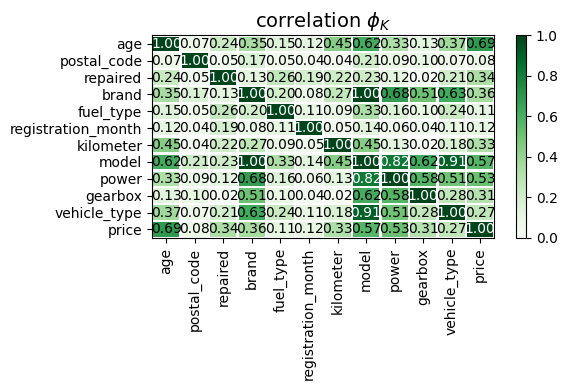

In [52]:

interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(6, 4))
plt.tight_layout()

Признак model сильно коррелирует с brand, power и vehicle_type
Месяц регистрации,почтовый индекс и тип топлива имеют слабую связь с целевым признаком

In [53]:
data = data.drop(['registration_month','model'], axis=1)

In [54]:
data.shape

(285968, 10)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Данные успешно обработаны 👍
</div>

## Обучение моделей

При первом обучении модели определили важность признаков, вернулись на данный этап для удаления маловажных признаков:fuel_type, gearbox, postal_code. RMSE после удаления ухудшилась,поэтому данные вернула.

In [55]:
#data = data.drop(['fuel_type','gearbox','postal_code'], axis=1)

Разобьем данные на тренировочную и тестовую выборки,на признаки и таргет.

In [56]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.25, random_state=12345)

In [57]:
print('обучающая:',features_train.shape[0]/data.shape[0])
print('тестовая:',features_test.shape[0]/data.shape[0])

обучающая: 0.75
тестовая: 0.25


In [58]:
features_train.head()

,vehicle_type,gearbox,power,kilometer,fuel_type,brand,repaired,postal_code,age
324366,small,auto,65,90000,petrol,opel,no,3099,17
164740,bus,auto,170,90000,petrol,volkswagen,no,41334,8
244143,other,manual,15,5000,other,bmw,unknown,27367,21
233898,sedan,manual,140,150000,petrol,audi,no,45279,10
136414,small,manual,80,125000,petrol,opel,no,57234,8


In [59]:
cat_columns = ['vehicle_type','gearbox','fuel_type','brand','repaired']
num_columns = ['power','kilometer','postal_code','age']

Масштабируем числовые признаки

In [60]:
scaler = StandardScaler()
scaler.fit(features_train[num_columns])
features_train[num_columns] = scaler.transform(features_train[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

Создадим копии тренировочного и тестового датасета, так как в дальнейшем будем использовать линейную регрессию,которая показываем лучший результат при прямом кодировании(One Hot Encoder).

In [61]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [62]:
# Таблица для сбора полученных результатов
models_scors = pd.DataFrame(columns = ['model', 'rmse_train','rmse_test','lirning_time', 'predicting_time'])

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Данные поделены верно, пропорции выбраны адекватные 👍
</div>

### Cat Boost

Подберем гиперпараметры

In [63]:
cat_model = cb.CatBoostRegressor(loss_function='RMSE',verbose=False,cat_features=cat_columns)

In [64]:

grid = {'iterations': [100,150,200],
        'learning_rate': [0.03,0.1],
        'depth': [ 6, 8, 10]
        }

In [65]:
%%time
cat_grid_result = cat_model.grid_search(grid,
                                       X=features_train,
                                       y=target_train
                                       )


bestTest = 2001.907522
bestIteration = 99

0:	loss: 2001.9075219	best: 2001.9075219 (0)	total: 12.9s	remaining: 3m 38s

bestTest = 1728.249949
bestIteration = 99

1:	loss: 1728.2499494	best: 1728.2499494 (1)	total: 24.6s	remaining: 3m 16s

bestTest = 1845.441736
bestIteration = 149

2:	loss: 1845.4417357	best: 1728.2499494 (1)	total: 41.4s	remaining: 3m 26s

bestTest = 1691.756599
bestIteration = 149

3:	loss: 1691.7565990	best: 1691.7565990 (3)	total: 57.4s	remaining: 3m 20s

bestTest = 1776.778666
bestIteration = 199

4:	loss: 1776.7786664	best: 1691.7565990 (3)	total: 1m 35s	remaining: 4m 7s

bestTest = 1657.951081
bestIteration = 199

5:	loss: 1657.9510807	best: 1657.9510807 (5)	total: 2m 14s	remaining: 4m 28s

bestTest = 1942.216338
bestIteration = 99

6:	loss: 1942.2163380	best: 1657.9510807 (5)	total: 2m 27s	remaining: 3m 52s

bestTest = 1676.293946
bestIteration = 99

7:	loss: 1676.2939458	best: 1657.9510807 (5)	total: 2m 41s	remaining: 3m 21s

bestTest = 1783.218521
bestItera

In [66]:
cat_score_train = cat_model.best_score_['learn']['RMSE']
print('RMSE на тренировочном наборе:',cat_score_train)

RMSE на тренировочном наборе: 1514.2263720913081


In [67]:
print('Параметры модели с наилучшим результатом:',cat_grid_result['params'])


Параметры модели с наилучшим результатом: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}


Text(0.5, 1.0, 'Важность признаков')

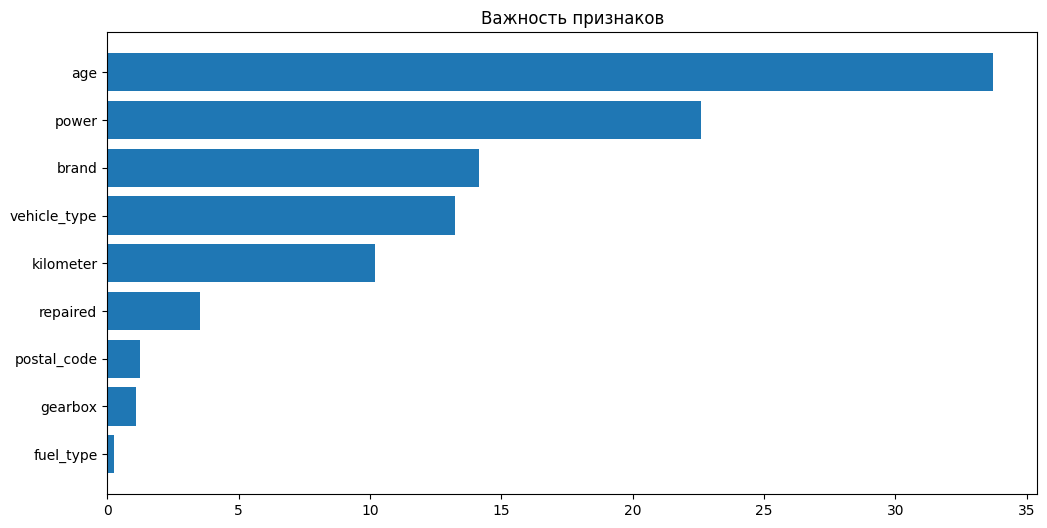

In [68]:

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Важность признаков')


Вернемся к моменту разбиения данных и удалим маловажные признаки: fuel_type, gearbox, postal_code\
На первом этапе(до удаления) RMSE на тренировочном наборе составляла 1514.226\
На втором этапе (после удаления) RMSE составила 1537.186, поэтому вернула данные.

Расчитаем время обучения и предсказания, и RMSE на тестовом наборе данных.

In [69]:
best_cat_model = cb.CatBoostRegressor(iterations=200, learning_rate=0.1, depth=10, loss_function='RMSE',verbose=False,cat_features=cat_columns)
start = time.time()
best_cat_model.fit(features_train, target_train)
end = time.time()
lirning_time_cat= end - start

start_time = time.time()
prediction = best_cat_model.predict(features_test)
predicting_time_cat = time.time() - start_time

scor = mean_squared_error(target_test, prediction,squared=False)

print(f'Время обучения :{lirning_time_cat}')
print(f'Время предсказания:{predicting_time_cat}')
print(f'RMSE на тестовом наборе данных:{scor}')

Время обучения :84.91687846183777
Время предсказания:0.22801589965820312
RMSE на тестовом наборе данных:1581.451221016357


In [70]:
models_scors = (models_scors.append({'model': 'CatBoostRegressor', 'rmse_train': cat_score_train,
                                     'rmse_test': scor,'lirning_time': lirning_time_cat ,
                                     'predicting_time': predicting_time_cat},ignore_index=True ))

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Модель обучена корректно 👍
</div>

### LGBMRegressor

Закодируем признаки порядковым кодированием

In [71]:
oe = OrdinalEncoder()
oe.fit_transform(features_train[cat_columns])
features_train[cat_columns] = oe.transform(features_train[cat_columns])
features_test[cat_columns] = oe.transform(features_test[cat_columns])

In [72]:
features_train.head()

,vehicle_type,gearbox,power,kilometer,fuel_type,brand,repaired,postal_code,age
324366,5.0,0.0,-1.109765,-1.054662,5.0,24.0,0.0,-1.870559,0.688596
164740,0.0,0.0,1.057613,-1.054662,5.0,38.0,0.0,-0.386186,-0.836128
244143,3.0,1.0,-2.141850,-3.382135,4.0,2.0,1.0,-0.928418,1.366251
233898,4.0,1.0,0.438362,0.588260,5.0,1.0,0.0,-0.233032,-0.497300
136414,5.0,1.0,-0.800140,-0.096291,5.0,24.0,0.0,0.231090,-0.836128


Подбираем параметры для LGBM

In [73]:
%%time
parameters = {'max_depth': range(10,30,5),
              'learning_rate': [0.03,0.1],
              'num_leaves':range(10,50,10)
              
}
gbm = LGBMRegressor(random_state=12345)

gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3)
gsearch.fit(features_train, target_train)

print("Лучшая RMSE: %0.3f" % gsearch.best_score_)
print("Лучшие параметры:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Лучшая RMSE: -1634.567
Лучшие параметры:
	learning_rate: 0.1
	max_depth: 15
	num_leaves: 40
CPU times: total: 4min 30s
Wall time: 1min 27s


Расчитываем время обучения и предсказания, а так же RMSE на тестовом наборе данных.

In [87]:
%%time
best_gbm_model = LGBMRegressor( learning_rate=0.1,max_depth=15, num_leaves = 40,random_state=12345)
start = time.time()
best_gbm_model.fit(features_train, target_train)
end = time.time()
lirning_time_gbm= end - start

start_time = time.time()
prediction = best_gbm_model.predict(features_test)
predicting_time_gbm = time.time() - start_time

scor_gbm = mean_squared_error(target_test, prediction,squared=False)

print(f'Время обучения :{lirning_time_gbm}')
print(f'Время предсказания:{predicting_time_gbm}')
print(f'RMSE на тестовом наборе данных:{scor_gbm}')

Время обучения :1.1721601486206055
Время предсказания:0.16801238059997559
RMSE на тестовом наборе данных:1632.915766259143
CPU times: total: 4.12 s
Wall time: 1.34 s


In [75]:
models_scors = (models_scors.append({'model': 'LGBMRegressor', 'rmse_train': abs(gsearch.best_score_),
                                     'rmse_test': scor_gbm,'lirning_time': lirning_time_gbm ,
                                     'predicting_time': predicting_time_gbm},ignore_index=True))

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Модель обучена корректно 👍
</div>

### LinearRegression

Закодируем категориальные признаки OHE поскольку,далее буду применять и линейную регрессию.Будем использовать ранее созданные копии тренировочного и тестового набора **features_train_ohe и features_test_ohe**

In [76]:
ohe = OneHotEncoder(sparse=False, drop='first')
train_ohe = ohe.fit_transform(features_train_ohe[cat_columns])
train_ohe = pd.DataFrame(train_ohe, columns=ohe.get_feature_names(cat_columns), index=features_train_ohe.index)
features_train_ohe[ohe.get_feature_names()] = train_ohe
features_train_ohe.drop(columns=cat_columns, inplace=True)

test_ohe = ohe.transform(features_test_ohe[cat_columns])
test_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names(cat_columns), index=features_test_ohe.index)
features_test_ohe[ohe.get_feature_names()] = test_ohe
features_test_ohe.drop(columns=cat_columns, inplace=True)


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Для линейных моделей прямое кодирование отлично подойдет 👍
</div>

In [77]:
%%time
model_lin = LinearRegression()
scores_lin = cross_val_score(model_lin, features_train_ohe, target_train, scoring='neg_root_mean_squared_error', cv=5) 
final_score_linear = pd.Series(scores_lin).mean()
print('RMSE на тренировочном наборе :', final_score_linear)

RMSE на тренировочном наборе : -2571.0094113679443
CPU times: total: 8.64 s
Wall time: 4.72 s


In [78]:
%%time
model_lin = LinearRegression()
start = time.time()
model_lin.fit(features_train_ohe, target_train)
end = time.time()
lirning_time_lin= end - start

start_time = time.time()
prediction = model_lin.predict(features_test_ohe)
predicting_time_lin = time.time() - start_time

scor_lin = mean_squared_error(target_test, prediction,squared=False)

print(f'Время обучения :{lirning_time_lin}')
print(f'Время предсказания:{predicting_time_lin}')
print(f'RMSE на тестовом наборе данных:{scor_lin}')

Время обучения :1.1885108947753906
Время предсказания:0.0420069694519043
RMSE на тестовом наборе данных:2577.6847885279926
CPU times: total: 2.05 s
Wall time: 1.23 s


In [79]:
models_scors = (models_scors.append({'model': 'LinearRegression', 'rmse_train': abs(final_score_linear),
                                     'rmse_test': scor_lin,'lirning_time': lirning_time_lin ,
                                     'predicting_time': predicting_time_lin},ignore_index=True))

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

Для линейных моделей стоит масштабировать численные признаки. Можешь выполнить это сразу после разбиения данных? Scaler обучаешь на тренировочной выборке, затем по очереди применяешь стандартизацию ко всем выборкам.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавила масштабирование после разбиения на выборки.
</div>

<div class="alert alert-block alert-success">
<b>V2 ✔️ Успешно исправлено</b>
</div>

### RandomForestRegressor

Подбираем гиперпараметры

In [80]:
%%time
parameters = {'max_depth': [5,10,15],
              'n_estimators':[5,30,50]}
rf = RandomForestRegressor(random_state=12345)

gsearch_rf = GridSearchCV(rf, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3)
gsearch_rf.fit(features_train, target_train)

print("Лучшая RMSE: %0.3f" % gsearch_rf.best_score_)
print("Лучшие параметры:")
best_parameters = gsearch_rf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Лучшая RMSE: -1629.553
Лучшие параметры:
	max_depth: 15
	n_estimators: 50
CPU times: total: 4min 35s
Wall time: 4min 40s


In [82]:
%%time
best_rf = RandomForestRegressor(max_depth=15,n_estimators=50 , random_state=12345)
start = time.time()
best_rf.fit(features_train, target_train)
end = time.time()
lirning_time_rf= end - start

start_time = time.time()
prediction = best_rf.predict(features_test)
predicting_time_rf = time.time() - start_time

scor_rf = mean_squared_error(target_test, prediction,squared=False)

print(f'Время обучения :{lirning_time_rf}')
print(f'Время предсказания:{predicting_time_rf}')
print(f'RMSE на тестовом наборе данных:{scor_rf}')



Время обучения :33.22890520095825
Время предсказания:0.7270603179931641
RMSE на тестовом наборе данных:1607.9536673676002
CPU times: total: 33.6 s
Wall time: 34 s


In [83]:
models_scors = (models_scors.append({'model': 'RandomForestRegressor', 'rmse_train': abs(gsearch_rf.best_score_),
                                     'rmse_test': scor_rf,'lirning_time': lirning_time_rf ,
                                     'predicting_time': predicting_time_rf},ignore_index=True))

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

Для моделей, основанных на деревьях решений, лучше использовать порядковое кодирование (OrdinalEncoder). Это должно ускорить их работу. Так как при большом количестве признаков, модель будет долго искать оптимальный сплит.

В этой кодировке важно преобразовать только категориальные признаки. Если этого не сделать, то целевая переменная тоже закодируется и метрики будут неадекватными.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Закодирова порядковым кодированием в пункте 2.2 и СПАСИБО за рекомендации, это значительно повысило скорость обработки, предсказания и обучения. И отдельное спасибо за дополнительную информацию)))
</div>

<div class="alert alert-block alert-success">
<b>V2 ✔️ Успешно исправлено</b>
</div>

## Анализ моделей

Посмотрим на полученные результаты по всем моделям.

In [84]:
models_scors.sort_values(by = 'rmse_test')

,model,rmse_train,rmse_test,lirning_time,predicting_time
0,CatBoostRegressor,1514.226372,1581.451221,84.916878,0.228016
3,RandomForestRegressor,1629.553327,1607.953667,33.228905,0.727060
1,LGBMRegressor,1634.566993,1632.156136,1.144691,0.190013
2,LinearRegression,2571.009411,2577.684789,1.188511,0.042007


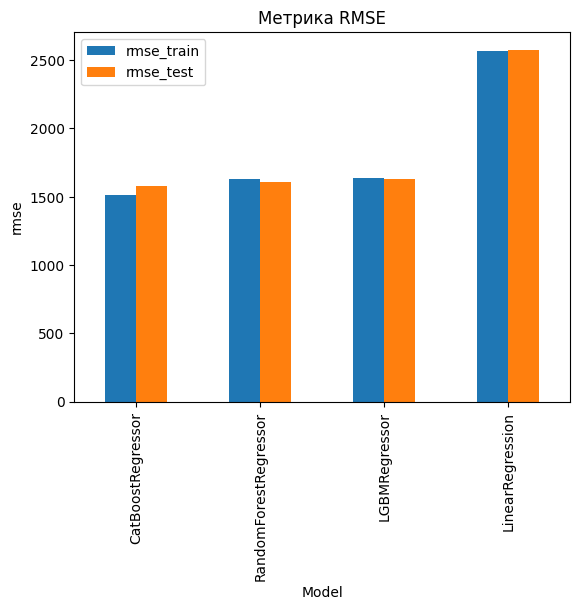

In [85]:
models_scors.sort_values(by = 'rmse_test').plot(x='model',y=['rmse_train','rmse_test'],kind='bar')
plt.xlabel("Model")
plt.ylabel("rmse")
plt.title('Метрика RMSE')
plt.legend(loc = 'best')
plt.show()

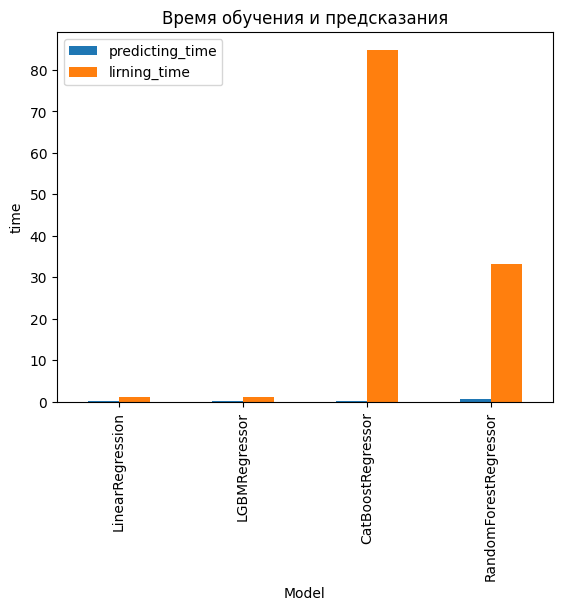

In [86]:
models_scors.sort_values(by = 'predicting_time').plot(x='model',y=['predicting_time','lirning_time'],kind='bar')
plt.xlabel("Model")
plt.ylabel("time")
plt.title('Время обучения и предсказания')
plt.legend(loc = 'best')
plt.show()

CatBoostRegressor и RandomForestRegressor лучше по показателю RMSE относительно LGBMRegressor, но она сильно выигрывает во времени обучения.Время предсказания у всех моделей невелико, однако и тут LGBMRegressor выигрывает у лидеров по показателям RMSE.\
LinearRegression показала хуже всех результаты RMSE, хотя по времени обучения быстрее всех.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Молодец, что для сравнения моделей заносишь их в общий датафрейм 👍
</div>

# Вывод

1. Данные имели очень много пропусков и нулевых значений,после предобработки,частью данных пришлось пожертвовать:
-  избавились от нулей в целевом признаке;
-  убрали аномальные значения в годах регистрации и мощности авто;
-  убрали неинформативные признаки и добавили возаст автомобиля(в результате этот признак имеет наибольшую важность в предсказании стоимости);

2. Проверка на мультиколениарность показала сильную связь признака model с другими признаками, его удалили.

3. Для тестирования выбрали 4 модели : CatBoostRegressor, RandomForestRegressor, LGBMRegressor, LinearRegression.\
Для оценки качества моделей применяли метрику RMSE.\
Методом GridSearch подобрали несколько параметров для этих моделей, после чего замерили скорости обучения и предсказания, а также метрику RMSE.

4. В результате по RMSE выигрывают CatBoostRegressor и RandomForestRegressor, но сильно уступает по времени обучения LGBMRegressor.\
Следовательно **лучшей моделью для заказчика предлагаю LGBMRegressor(learning_rate=0.1,max_depth=15, num_leaves = 40,random_state=12345)**


Считаю, что более тщательный подбор гиперпараметров, позволит добиться лучшей метрики.\
Так же необходимо обсудить данные с заказчиком и возможность получения дополнительной информации, особенно по признаку power, где потеряно много данных из-за нулей.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Вывод соответствует анализу 👍 Значит рекомендуем заказчику LGBM
</div>

# <font color='orange'>Общее впечатление</font>
* Этот проект выполнен очень хорошо
* Видно, что приложено много усилий
* Молодец, что структурируешь ноутбук, приятно проверять такие работы
* У тебя чистый и лаконичный код
* Мне было интересно читать твои промежуточные выводы
* Твой уровень подачи материала находится на высоком уровне
* Исправь, пожалуйста, мои замечания. Затем отправляй на повторную проверку
* Жду новую версию проекта 👋

# <font color='orange'>2. Общее впечатление</font>
* Спасибо за быстрое внесение правок
* Теперь проект выглядит лучше )
* Критических замечаний нет
* Молодец, отличная работа!
* Надеюсь, ревью было полезным
* Удачи в дальнейшем обучении 👋

# <font color='orange'>Рекомендации 🔥</font>
* Доступное объяснение про работу градиентного бустинга https://www.youtube.com/watch?v=ZNJ3lKyI-EY&t=995s
* После просмотра видео можешь почитать статью про ансамбли и бустинги https://habr.com/ru/company/ods/blog/645887/
* Подбор гиперпараметров для CatBoost https://habr.com/ru/company/otus/blog/527554/
* Подбор гиперпараметров для LightGBM https://programmersought.com/article/40776531516/
* Разумные способы кодирования категориальных данных для машинного обучения https://machinelearningmastery.ru/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159/
* Статья про "непонятную" метрику ROC-AUC https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
* Хочешь подтянуть математику для DS?) https://academy.stepik.org/math-for-data-science
* Результы обучения моделей можно визуализировать 😎 https://www.datatechnotes.com/2019/08/elasticnet-regression-example-in-python.html
* В нашем деле нужно быть всегда в курсе всех новинок, новостей и тд, вот тут публикуют новости в области DS: https://www.infoq.com/data-analysis/news/
* Всем аналитикам данных рекомендую книгу Даниела Канемана "Думай медленно, решай быстро"